<a href="https://colab.research.google.com/github/harnettd/learn-PyTorch/blob/main/01-PyTorch-Workflow-Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Workflow Fundamentals

In [1]:
!git clone https://github.com/harnettd/learn-PyTorch.git
%cd learn-PyTorch

fatal: destination path 'learn-PyTorch' already exists and is not an empty directory.
/content/learn-PyTorch


## Installs and Imports

In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
torch.__version__

'2.3.1+cu121'

## Prepare and Load Data

In [4]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [5]:
train_len = int(0.8 * len(X))

# X, y should probably be shuffled
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="orange", s=4, label="Testing data")

    if predictions is not None:
      # Plot the predictions in red (predictions were made on the test data)
      plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.xlabel('data')
    plt.ylabel('label')

    # Show the legend
    plt.legend(prop={"size": 12});

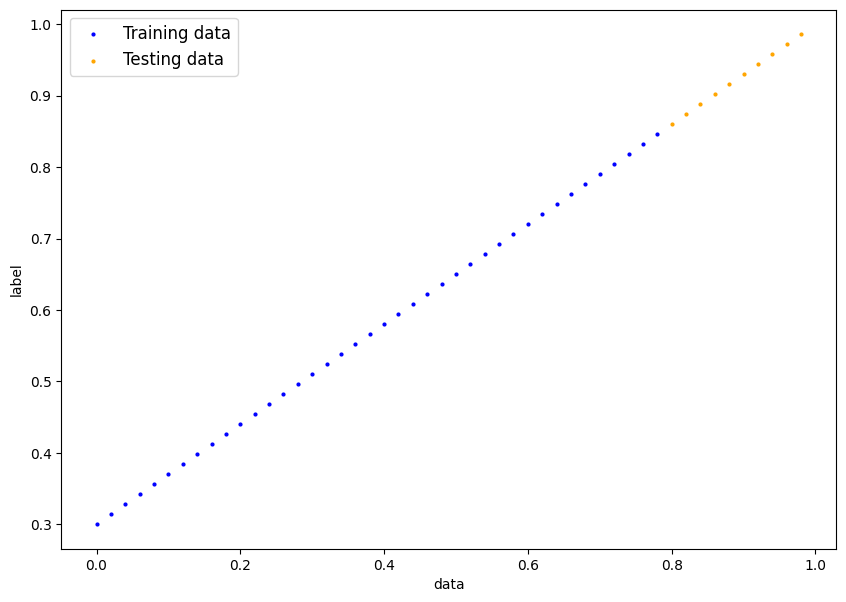

In [7]:
plot_predictions()

## Build Model

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            requires_grad=True
        )
        self.bias = nn.Parameter(
            torch.randn(1, dtype=torch.float),
            requires_grad=True
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [9]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [11]:
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

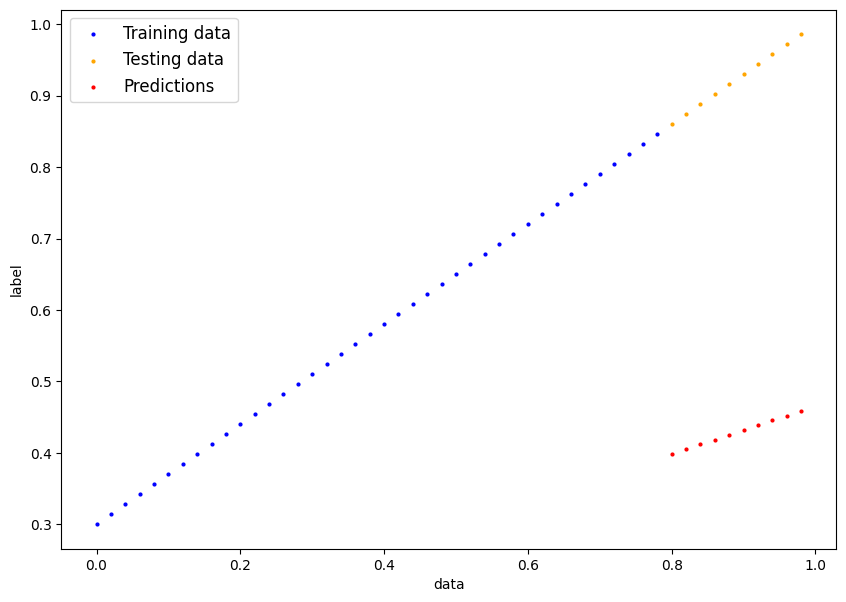

In [12]:
plot_predictions(predictions=y_pred)

## Train Model

In [13]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01
)

In [14]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    # Train
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Test
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Printout
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f'Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}')

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


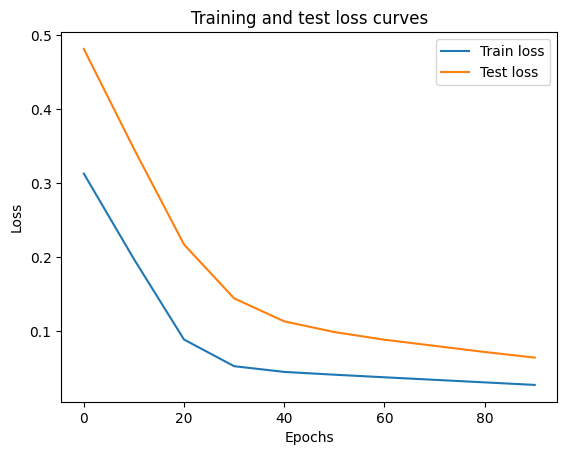

In [15]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

## Make Predictions

In [17]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0(X_test)
y_pred

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

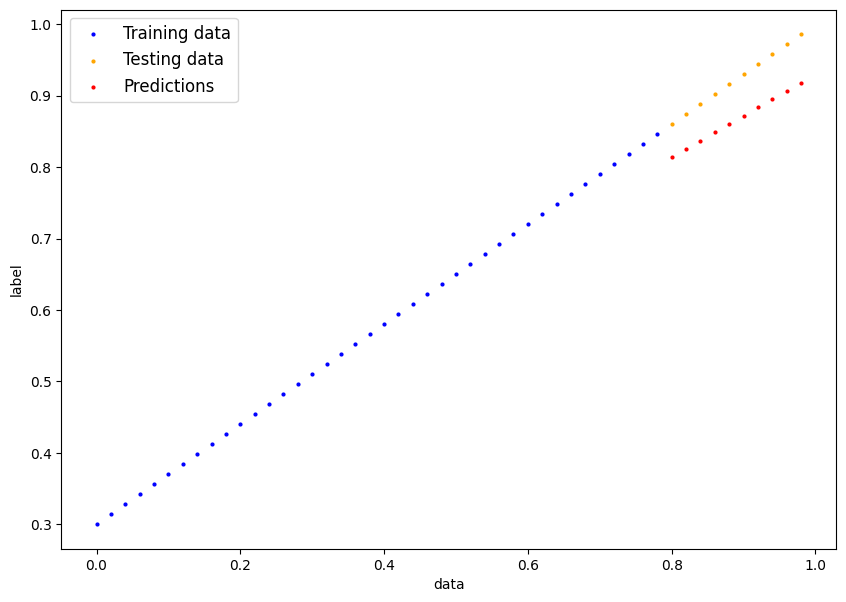

In [18]:
plot_predictions(predictions=y_pred)

## Save and Load a PyTorch Model

In [22]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [23]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_pred = loaded_model_0(X_test)

In [25]:
y_pred == loaded_model_0_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])